In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split   # for splitting data
from sklearn.preprocessing import LabelEncoder         # for encoding categorical variables

# Metrics for classification/regression evaluation
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             mean_absolute_error, mean_squared_error, r2_score)

# Machine Learning models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer   # for text feature extraction
from sklearn.naive_bayes import MultinomialNB                 # for text classification
from sklearn.cluster import KMeans                            # for clustering

# Time Series Forecasting
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load dataset
df = pd.read_csv("D:\downloads\crime_dataset_india(1).csv")

In [3]:
# View data
print(df.head())
print(df.info())
print(df.describe())

# Check missing values
print(df.isnull().sum())

# Convert dates
df['Date Reported'] = pd.to_datetime(df['Date Reported'], errors='coerce', dayfirst=True)
df['Date of Occurrence'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce', dayfirst=True)
df['Date Case Closed'] = pd.to_datetime(df['Date Case Closed'], errors='coerce', dayfirst=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Feature engineering
df['Case Duration'] = (df['Date Case Closed'] - df['Date Reported']).dt.days


   Report Number Date Reported Date of Occurrence Time of Occurrence  \
0              1    02-01-2020         01-01-2020           01:11:00   
1              2    01-01-2020         01-01-2020           06:26:00   
2              3    02-01-2020         01-01-2020           14:30:00   
3              4    01-01-2020         01-01-2020           14:46:00   
4              5    01-01-2020         01-01-2020           16:51:00   

        City  Crime Code Crime Description  Victim Age Victim Gender  \
0  Ahmedabad         576    IDENTITY THEFT          16             M   
1    Chennai         128          HOMICIDE          37             M   
2   Ludhiana         271        KIDNAPPING          48             F   
3       Pune         170          BURGLARY          49             F   
4       Pune         421         VANDALISM          30             F   

    Weapon Used   Crime Domain  Police Deployed Case Closed Date Case Closed  
0  Blunt Object  Violent Crime               13        

In [4]:
#obj1
# Encode the target variable 'Case Closed'
# 'Yes' (Closed) -> 1, 'No' (Pending) -> 0
le = LabelEncoder()
df['Case_Status'] = le.fit_transform(df['Case Closed'])

# Check encoding counts
print(df['Case Closed'].value_counts())
print(df['Case_Status'].value_counts())

# Features selection - choose categorical and numerical relevant features
X = df[['City', 'Crime Domain', 'Police Deployed']]  # you can add other features if relevant
y = df['Case_Status']

# One-hot encode categorical features in X (City, Crime Domain)
X = pd.get_dummies(X, drop_first=True)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

# Instantiate Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model
log_reg.fit(X_train, y_train)

# Make predictions on test set
y_pred = log_reg.predict(X_test)

# Evaluate model
print("🔹 Accuracy:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Case Closed
No     20098
Yes    20062
Name: count, dtype: int64
Case_Status
0    20098
1    20062
Name: count, dtype: int64
🔹 Accuracy: 0.4958914342629482

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.42      0.46      4020
           1       0.50      0.57      0.53      4012

    accuracy                           0.50      8032
   macro avg       0.50      0.50      0.49      8032
weighted avg       0.50      0.50      0.49      8032


🔹 Confusion Matrix:
 [[1708 2312]
 [1737 2275]]


In [15]:
#hypothesis
# Contingency table: City vs Case Status
contingency = pd.crosstab(df['City'], df['Case Closed'])

# Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency)
print("Objective 1 - Case Status Prediction")
print(f"Chi2 Statistic: {chi2}, p-value: {p}")
if p < 0.05:
    print("Reject H0: Case status depends on city or features.\n")
else:
    print("Fail to reject H0: Case status is independent.\n")


Objective 1 - Case Status Prediction
Chi2 Statistic: 27.364567804374918, p-value: 0.4984684119622621
Fail to reject H0: Case status is independent.



In [5]:
#obj2
# Filter only closed cases for closure time prediction
closed_cases = df[df['Case Closed'] == 'Yes'].copy()
closed_cases['Date Reported'] = pd.to_datetime(closed_cases['Date Reported'], dayfirst=True)
closed_cases['Date Case Closed'] = pd.to_datetime(closed_cases['Date Case Closed'], dayfirst=True)
closed_cases['Closure_Time'] = (closed_cases['Date Case Closed'] - closed_cases['Date Reported']).dt.days

X = closed_cases[['City', 'Crime Domain', 'Police Deployed']]
y = closed_cases['Closure_Time']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 74.66576841643857
MSE: 17256.866582541552
R2 Score: -0.04741717962802783


In [16]:

#hypothesis
# Example: closure time by crime type
df['Closure Time'] = (pd.to_datetime(df['Date Case Closed'], errors='coerce') - 
                      pd.to_datetime(df['Date of Occurrence'], errors='coerce')).dt.days

# Drop NaNs
df_ct = df.dropna(subset=['Closure Time', 'Crime Domain'])

# ANOVA test: Does closure time differ by crime domain?
groups = [group['Closure Time'].values for name, group in df_ct.groupby('Crime Domain')]
f_stat, p = f_oneway(*groups)
print("Objective 2 - Closure Time Estimation")
print(f"F-statistic: {f_stat}, p-value: {p}")
if p < 0.05:
    print("Reject H0: Closure time varies by crime domain.\n")
else:
    print("Fail to reject H0: Closure time is independent.\n")


Objective 2 - Closure Time Estimation
F-statistic: 123.71345617341339, p-value: 2.724020490864678e-78
Reject H0: Closure time varies by crime domain.



In [6]:
#obj3
# Encode target: Crime Description (you can filter or encode more sophisticatedly)
df['Crime_Description'] = df['Crime Description'].astype(str)
y = df['Crime_Description']
X = df['Crime Description']  # text features

# Vectorize text data
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, 
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
                      precision    recall  f1-score   support

              ARSON       1.00      1.00      1.00       379
            ASSAULT       1.00      1.00      1.00       383
           BURGLARY       1.00      1.00      1.00       396
     COUNTERFEITING       1.00      1.00      1.00       374
         CYBERCRIME       1.00      1.00      1.00       380
  DOMESTIC VIOLENCE       1.00      1.00      1.00       386
       DRUG OFFENSE       1.00      1.00      1.00       378
          EXTORTION       1.00      1.00      1.00       375
    FIREARM OFFENSE       1.00      1.00      1.00       386
              FRAUD       1.00      1.00      1.00       393
           HOMICIDE       1.00      1.00      1.00       382
     IDENTITY THEFT       1.00      1.00      1.00       384
 ILLEGAL POSSESSION       1.00      1.00      1.00       379
         KIDNAPPING       1.00      1.00      1.00       384
PUBLIC INTOXICATION       1.00      1.00      

In [17]:
#hypothesis
# Prepare features and labels
X = df['Crime Description'].fillna('')
y = df['Crime Domain']

# Convert text to numeric features
vectorizer = TfidfVectorizer(max_features=500)
X_vec = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate
print("Objective 3 - Crime Type Prediction")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Objective 3 - Crime Type Prediction
Accuracy: 1.0
                  precision    recall  f1-score   support

   Fire Accident       1.00      1.00      1.00       737
     Other Crime       1.00      1.00      1.00      4580
Traffic Fatality       1.00      1.00      1.00       393
   Violent Crime       1.00      1.00      1.00      2322

        accuracy                           1.00      8032
       macro avg       1.00      1.00      1.00      8032
    weighted avg       1.00      1.00      1.00      8032



In [19]:
#obj 4

# Aggregate crime counts by city
city_crime_counts = df['City'].value_counts().reset_index()
city_crime_counts.columns = ['City', 'Crime_Count']

# KMeans clustering with 2 clusters (high risk and low risk)
km = KMeans(n_clusters=2, random_state=42)
city_crime_counts['Cluster'] = km.fit_predict(city_crime_counts[['Crime_Count']])

print(city_crime_counts.sort_values('Cluster'))


             City  Crime_Count  Cluster
7       Ahmedabad         1817        0
14       Ludhiana          761        0
13           Agra          764        0
12         Nagpur         1053        0
11          Surat         1111        0
10         Kanpur         1112        0
9         Lucknow         1456        0
8          Jaipur         1479        0
15  Visakhapatnam          728        0
22       Srinagar          371        0
21         Meerut          395        0
20         Bhopal          690        0
19          Patna          695        0
18         Indore          699        0
17      Ghaziabad          704        0
16          Thane          706        0
24          Vasai          362        0
25       Varanasi          355        0
26         Kalyan          355        0
27      Faridabad          354        0
28         Rajkot          320        0
23         Nashik          366        0
6            Pune         2212        1
4         Kolkata         2518        1


Objective 4 - City-wise Risk Analysis
             City  Crime Count  Risk Zone
5           Delhi         5400          1
17         Mumbai         4415          1
2       Bangalore         3588          1
8       Hyderabad         2881          1
13        Kolkata         2518          1
4         Chennai         2493          1
21           Pune         2212          1
1       Ahmedabad         1817          0
10         Jaipur         1479          0
14        Lucknow         1456          0
12         Kanpur         1112          0
24          Surat         1111          0
18         Nagpur         1053          0
0            Agra          764          0
15       Ludhiana          761          0
28  Visakhapatnam          728          0
25          Thane          706          0
7       Ghaziabad          704          0
9          Indore          699          0
20          Patna          695          0
3          Bhopal          690          0
16         Meerut          395        

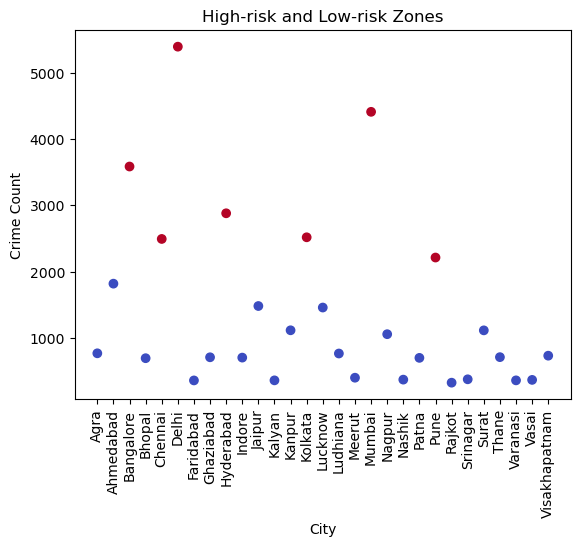

In [20]:
#hypothesis
# Aggregate crime counts per city
city_counts = df.groupby('City')['Report Number'].count().reset_index()
city_counts.rename(columns={'Report Number':'Crime Count'}, inplace=True)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
city_counts['Risk Zone'] = kmeans.fit_predict(city_counts[['Crime Count']])

print("Objective 4 - City-wise Risk Analysis")
print(city_counts.sort_values('Crime Count', ascending=False))

# Plot clusters
plt.scatter(city_counts['City'], city_counts['Crime Count'], c=city_counts['Risk Zone'], cmap='coolwarm')
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Crime Count')
plt.title('High-risk and Low-risk Zones')
plt.show()


In [21]:
#obj 5
X = df[['City', 'Crime Domain', 'Police Deployed']]  # include other predictors as needed
y = df['Police Deployed']  # If you want to predict deployment, you may need to rethink this

# Possibly target deployment based on other features (exclude Police Deployed from features)
X = df[['City', 'Crime Domain']]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 4.7276551088739955
MSE: 29.991438081968358
R2 Score: -0.007257284234137629


In [23]:
#hypothesis
import statsmodels.api as sm

# Features: Crime Code, Victim Age
X = df[['Crime Code','Victim Age']]
y = df['Police Deployed']

# Add constant for intercept
X = sm.add_constant(X)

# Linear Regression
model = sm.OLS(y, X).fit()
print("Objective 5 - Police Deployment Optimization")
print(model.summary())


Objective 5 - Police Deployment Optimization
                            OLS Regression Results                            
Dep. Variable:        Police Deployed   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.517
Date:                Fri, 12 Sep 2025   Prob (F-statistic):              0.219
Time:                        14:51:52   Log-Likelihood:            -1.2521e+05
No. Observations:               40160   AIC:                         2.504e+05
Df Residuals:                   40157   BIC:                         2.505e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

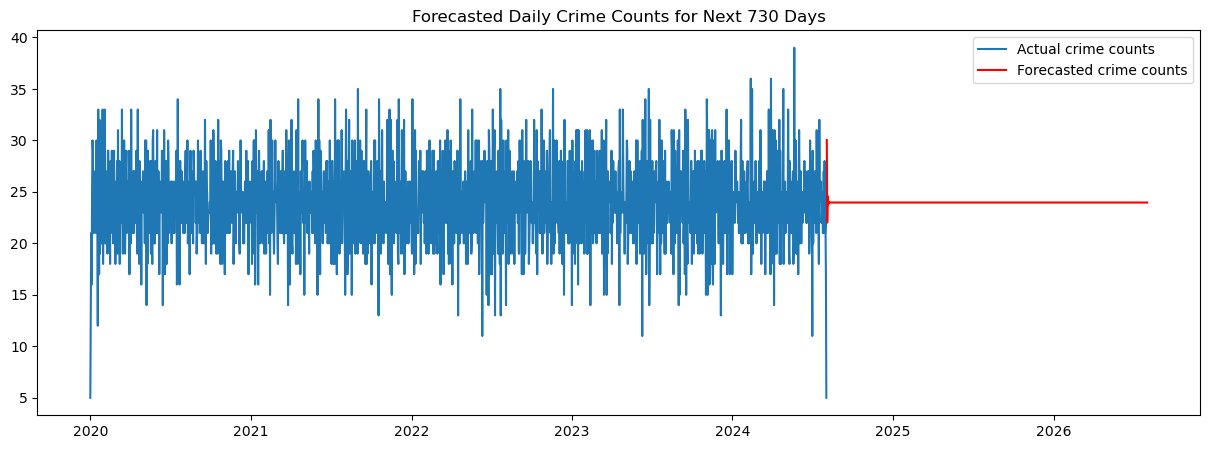

In [24]:
#obj 6
# Number of days you want to forecast (e.g., 365*2 for 2 years ahead)
num_forecast_days = 365 * 2  # for 2 years

# Fit ARIMA model as before
model = ARIMA(crime_time_series, order=(1,1,1))
model_fit = model.fit()

# Forecast for the specified number of days
forecast = model_fit.forecast(steps=num_forecast_days)

# Create date range for future predictions
last_date = crime_time_series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=num_forecast_days, freq='D')

# Plot actual vs. forecast
plt.figure(figsize=(15,5))
plt.plot(crime_time_series.index, crime_time_series, label='Actual crime counts')
plt.plot(future_dates, forecast, label='Forecasted crime counts', color='red')
plt.legend()
plt.title(f'Forecasted Daily Crime Counts for Next {num_forecast_days} Days')
plt.show()


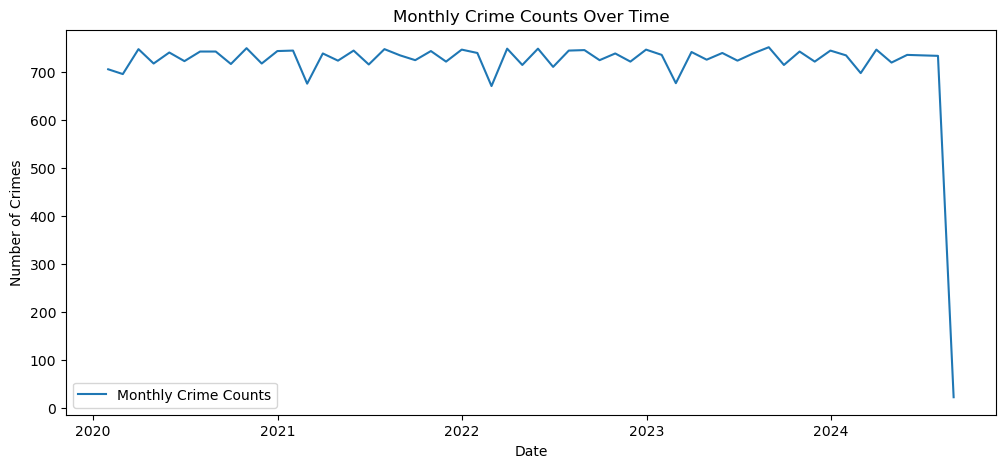

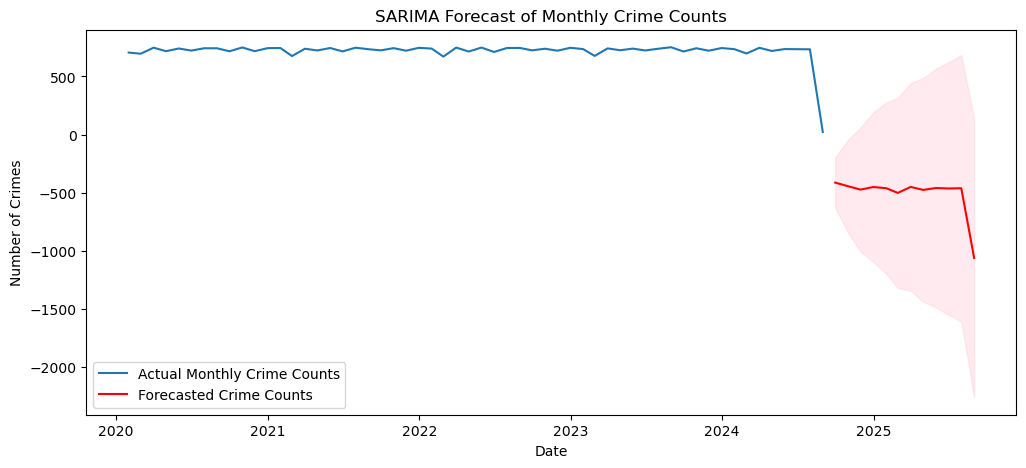

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df is your DataFrame already loaded

# Step 1: Convert 'Date Reported' to datetime (if not already done)
df['Date Reported'] = pd.to_datetime(df['Date Reported'], dayfirst=True)

# Step 2: Aggregate crime counts monthly
monthly_crime = df.groupby(pd.Grouper(key='Date Reported', freq='M')).size()
monthly_crime.name = 'Crime_Count'

# Step 3: Visualize monthly crime counts
plt.figure(figsize=(12,5))
plt.plot(monthly_crime, label='Monthly Crime Counts')
plt.title('Monthly Crime Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

# Step 4: Fit Seasonal ARIMA (SARIMA) model
# Seasonal order (p,d,q,s) with s=12 for monthly seasonality
model = SARIMAX(monthly_crime, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Step 5: Forecast next 12 months
forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_crime.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')

# Step 6: Plot actual and forecasted values
plt.figure(figsize=(12,5))
plt.plot(monthly_crime, label='Actual Monthly Crime Counts')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted Crime Counts', color='red')
plt.fill_between(forecast_index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color='pink', alpha=0.3)
plt.title('SARIMA Forecast of Monthly Crime Counts')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()


Highest crime city: Delhi


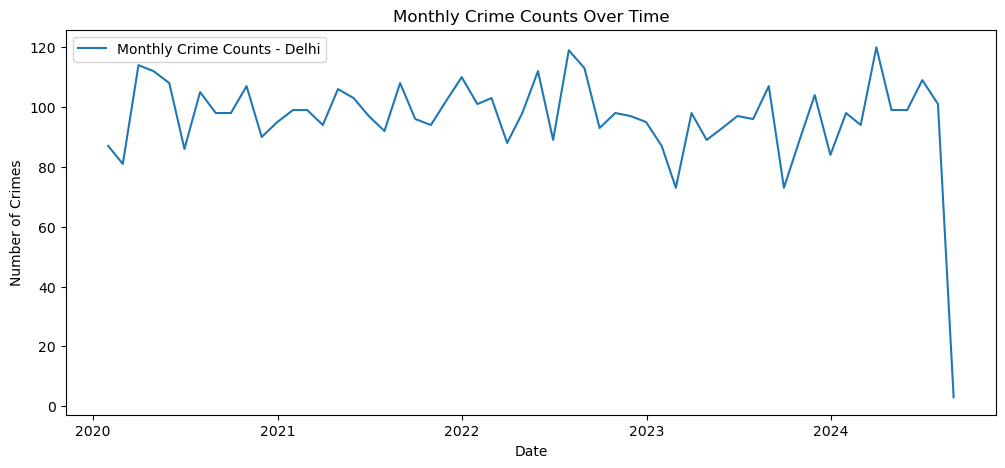

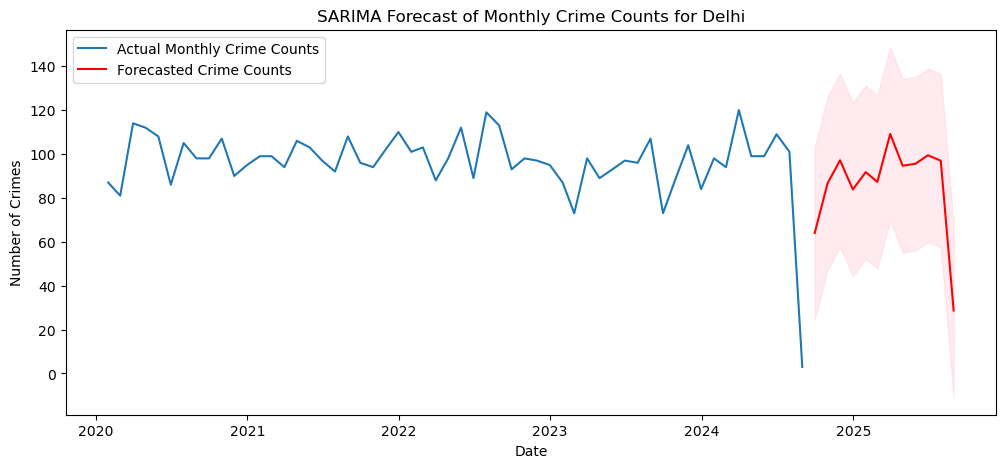

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Identify highest crime rate city
highest_crime_city = df['City'].value_counts().idxmax()
print(f"Highest crime city: {highest_crime_city}")

# Step 2: Filter dataset for that city
city_df = df[df['City'] == highest_crime_city].copy()

# Step 3: Aggregate monthly crime counts in the city
city_df['Date Reported'] = pd.to_datetime(city_df['Date Reported'], dayfirst=True)
monthly_crime_city = city_df.groupby(pd.Grouper(key='Date Reported', freq='M')).size()
monthly_crime_city.name = 'Crime_Count'

# Step 4: Plot monthly crime counts
plt.figure(figsize=(12,5))
plt.plot(monthly_crime_city, label=f'Monthly Crime Counts - {highest_crime_city}')
plt.title('Monthly Crime Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

# Step 5: Fit SARIMA model (with assumed parameters; tune if desired)
model = SARIMAX(monthly_crime_city, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Step 6: Forecast next 12 months
forecast_steps = 12
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_crime_city.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')

# Step 7: Plot actual and forecasted values
plt.figure(figsize=(12,5))
plt.plot(monthly_crime_city, label='Actual Monthly Crime Counts')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted Crime Counts', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title(f'SARIMA Forecast of Monthly Crime Counts for {highest_crime_city}')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()


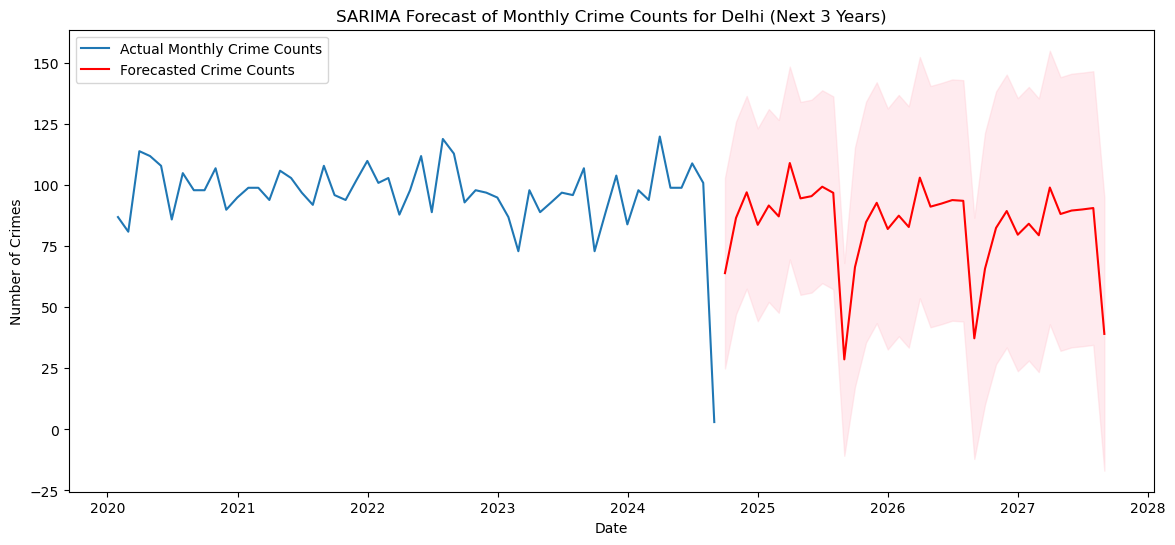

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming df and highest_crime_city are defined as before

# Filter data for highest crime city
city_df = df[df['City'] == highest_crime_city].copy()
city_df['Date Reported'] = pd.to_datetime(city_df['Date Reported'], dayfirst=True)

# Aggregate monthly crime counts
monthly_crime_city = city_df.groupby(pd.Grouper(key='Date Reported', freq='M')).size()
monthly_crime_city.name = 'Crime_Count'

# Fit SARIMA model (use tuned parameters or keep defaults)
model = SARIMAX(monthly_crime_city, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Forecast next 36 months (3 years)
forecast_steps = 36
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=monthly_crime_city.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')

# Plot actual and forecasted values
plt.figure(figsize=(14,6))
plt.plot(monthly_crime_city, label='Actual Monthly Crime Counts')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecasted Crime Counts', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title(f'SARIMA Forecast of Monthly Crime Counts for {highest_crime_city} (Next 3 Years)')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()


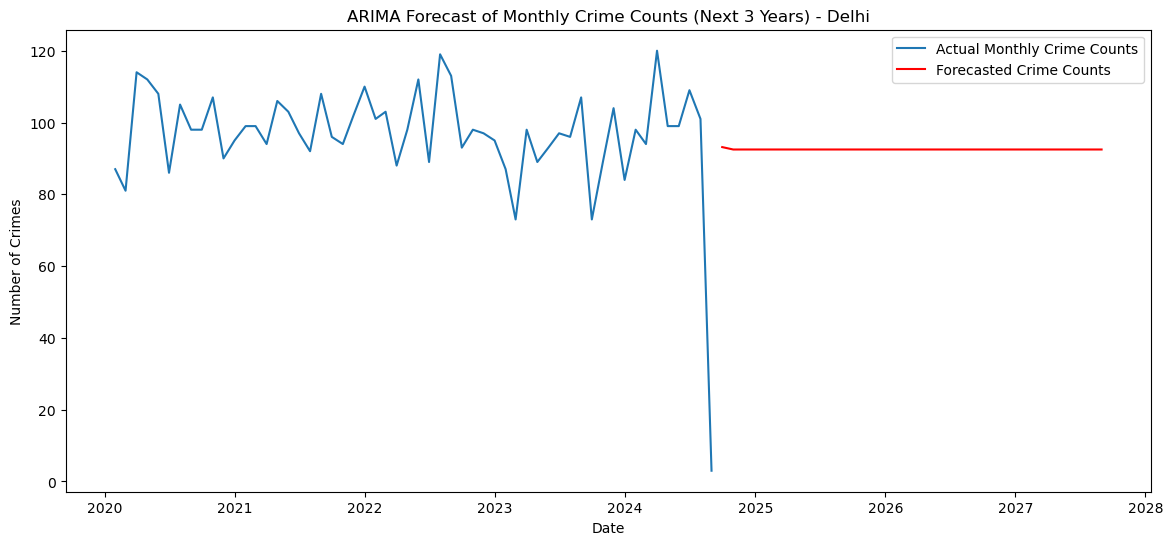

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Aggregate monthly crime counts for highest crime city (as before)
city_df = df[df['City'] == highest_crime_city].copy()
city_df['Date Reported'] = pd.to_datetime(city_df['Date Reported'], dayfirst=True)
monthly_crime_city = city_df.groupby(pd.Grouper(key='Date Reported', freq='M')).size()

# Fit a simple ARIMA model (p,d,q) — start with (1,1,1) or other syllabus-appropriate values
model = ARIMA(monthly_crime_city, order=(1,1,1))
model_fit = model.fit()

# Forecast next 36 months (3 years)
forecast_steps = 36
forecast = model_fit.forecast(steps=forecast_steps)

# Create forecast index dates
forecast_index = pd.date_range(start=monthly_crime_city.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(monthly_crime_city.index, monthly_crime_city, label='Actual Monthly Crime Counts')
plt.plot(forecast_index, forecast, label='Forecasted Crime Counts', color='red')
plt.title(f'ARIMA Forecast of Monthly Crime Counts (Next 3 Years) - {highest_crime_city}')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()


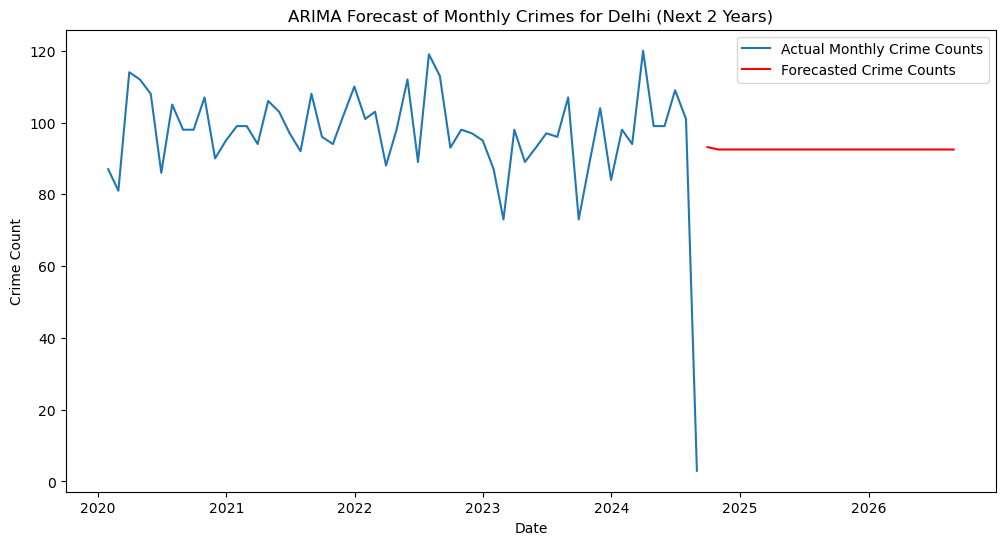

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Filter data for highest crime city
highest_crime_city = df['City'].value_counts().idxmax()
city_df = df[df['City'] == highest_crime_city].copy()
city_df['Date Reported'] = pd.to_datetime(city_df['Date Reported'], dayfirst=True)

# Aggregate monthly crime counts
monthly_crime_city = city_df.groupby(pd.Grouper(key='Date Reported', freq='M')).size()

# Fit ARIMA(1,1,1) — basic parameters
model = ARIMA(monthly_crime_city, order=(1,1,1))
model_fit = model.fit()

# Forecast next 24 months (2 years)
forecast_steps = 24
forecast = model_fit.forecast(steps=forecast_steps)

# Prepare forecast index
forecast_index = pd.date_range(start=monthly_crime_city.index[-1] + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')

# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(monthly_crime_city.index, monthly_crime_city, label='Actual Monthly Crime Counts')
plt.plot(forecast_index, forecast, label='Forecasted Crime Counts', color='red')
plt.title(f'ARIMA Forecast of Monthly Crimes for {highest_crime_city} (Next 2 Years)')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()


Number of potential hotspots detected: 2008
         City   Crime Description  Victim Age  Police Deployed  is_anomaly
14  Bangalore      SEXUAL ASSAULT          77               19           1
18  Bangalore          CYBERCRIME          11                3           1
48     Jaipur  ILLEGAL POSSESSION          77               17           1
55     Meerut            BURGLARY          49               19           1
87     Rajkot             ROBBERY          11                1           1


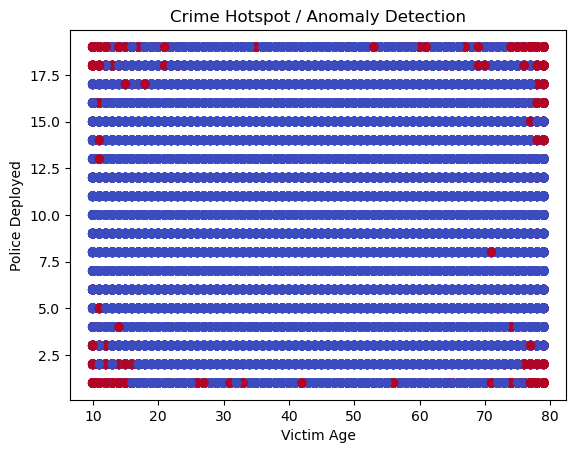

In [13]:
#obj 6
# Convert dates to datetime
df['Date of Occurrence'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce')
df['Date Reported'] = pd.to_datetime(df['Date Reported'], errors='coerce')

# Create numeric features for anomaly detection
# Example: Victim Age, Police Deployed, Crime Code
features = ['Victim Age', 'Police Deployed', 'Crime Code']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(X_scaled)

# Mark anomalies (1 = anomaly, 0 = normal)
df['is_anomaly'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# View detected hotspots / unusual cases
hotspots = df[df['is_anomaly'] == 1]
print(f"Number of potential hotspots detected: {len(hotspots)}")
print(hotspots[['City', 'Crime Description', 'Victim Age', 'Police Deployed', 'is_anomaly']].head())

# Optional: Visualize anomalies
plt.scatter(df['Victim Age'], df['Police Deployed'], c=df['is_anomaly'], cmap='coolwarm')
plt.xlabel('Victim Age')
plt.ylabel('Police Deployed')
plt.title('Crime Hotspot / Anomaly Detection')
plt.show()


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from scipy.stats import chi2_contingency

# Features for anomaly detection
features = ['Victim Age', 'Police Deployed', 'Crime Code']
X = df[features].fillna(0)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = iso.fit_predict(X_scaled)
df['is_anomaly'] = df['anomaly'].apply(lambda x: 1 if x==-1 else 0)

# Chi-Square test: anomalies vs city
contingency = pd.crosstab(df['City'], df['is_anomaly'])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Objective 6 - Crime Hotspots / Anomaly Detection")
print(f"Chi2: {chi2}, p-value: {p}")
if p < 0.05:
    print("Reject H0: Significant hotspots detected.\n")
else:
    print("Fail to reject H0: No significant hotspots.\n")


Objective 6 - Crime Hotspots / Anomaly Detection
Chi2: 26.296511576544486, p-value: 0.5567499133507865
Fail to reject H0: No significant hotspots.

